# Complete Workflow for generating ATS input for Coweeta

This workflow provides a complete working example to develop a simulation campaign for integrated hydrology within ATS.  

It uses the following datasets:

* `NHD Plus` for hydrography.
* `3DEP` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `MODIS` for LAI
* `GLYHMPS` geology data for structural formations
* `Pelletier` for depth to bedrock and soil texture information
* `SSURGO` for soil data, where available, in the top 2m.

Given some basic inputs (in the next cell) including a NAME, this workflow creates the following files, all of which will reside in output_data:

* Mesh file: `Coweeta.exo`, includes all labeled sets
* Forcing: DayMet data -- daily raster of precip, RH, incoming radiation, etc.
  - `Coweeta_daymet_2010_2011.h5`, the DayMet data on this watershed
  - `Coweeta_daymet_CyclicSteadystate.h5`, a "typical year" of DayMet, smoothed for spinup purposes, then looped certain number of years
* Forcing: LAI data -- every 4 days, time series by land cover type of LAI.
  - `Coweeta_LAI_MODIS_transient.h5`, the LAI, interpolated and smoothed from the raw MODIS data
  - `Coweeta_LAI_MODIS_CyclicSteadystate.h5`, a "typical year" of LAI, smoothed for spinup purposes then looped 10 years
* ATS Input files for three runs, intended to be run sequentially:
  - `Coweeta_steadystate.xml` the steady-state solution based on uniform application of mean rainfall rate
  - `Coweeta_cyclic_steadystate.xml` the cyclic steady state based on typical years
  - `Coweeta_transient.xml` the forward model, run from 2010 -- 2011


In [1]:
# these can be turned on for development work
%load_ext autoreload
%autoreload 2

In [2]:
## FIX ME -- why is this broken without importing netcdf first?
import netCDF4

In [3]:
# setting up logging first or else it gets preempted by another package
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)

In [4]:
import os,sys
import logging
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import pandas as pd
import geopandas as gpd
import cftime, datetime
pd.options.display.max_columns = None


## provide paths to relevant packages for mesh and input file generation 
# Set paths to relevant packages for mesh and input file generation
# Update these paths to match your local installation
#
#sys.path.append('/path/to/seacas/lib')
#%set_env AMANZI_SRC_DIR=/path/to/amanzi
#%set_env ATS_SRC_DIR=/path/to/amanzi/src/physics/ats
#sys.path.append('/path/to/amanzi/tools/amanzi_xml')


import watershed_workflow 
import watershed_workflow.config
import watershed_workflow.sources
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.meteorology
import watershed_workflow.land_cover_properties
import watershed_workflow.resampling
import watershed_workflow.condition
import watershed_workflow.io
import watershed_workflow.sources.standard_names as names

import ats_input_spec
import ats_input_spec.public
import ats_input_spec.io

import amanzi_xml.utils.io as aio
import amanzi_xml.utils.search as asearch
import amanzi_xml.utils.errors as aerrors

# set the default figure size for notebooks
plt.rcParams["figure.figsize"] = (8, 6)


print(watershed_workflow.__file__)

/home/ecoon/code/watershed_workflow/repos/master/watershed_workflow/__init__.py


## Input: Parameters and other source data

Note, this section will need to be modified for other runs of this workflow in other regions.

In [5]:
# Force Watershed Workflow to pull data from this directory rather than a shared data directory.
# This picks up the Coweeta-specific datasets set up here to avoid large file downloads for 
# demonstration purposes.
#
def splitPathFull(path):
    """
    Splits an absolute path into a list of components such that
    os.path.join(*splitPathFull(path)) == path
    """
    parts = []
    while True:
        head, tail = os.path.split(path)
        if head == path:  # root on Unix or drive letter with backslash on Windows (e.g., C:\)
            parts.insert(0, head)
            break
        elif tail == path:  # just a single file or directory
            parts.insert(0, tail)
            break
        else:
            parts.insert(0, tail)
            path = head
    return parts

cwd = splitPathFull(os.getcwd())

# REMOVE THIS PORTION OF THE CELL for general use outside of Coweeta -- this is just locating 
# the working directory within the WW directory structure
if cwd[-1] == 'Coweeta':
    pass
elif cwd[-1] == 'examples':
    cwd.append('Coweeta')
else:
    cwd.extend(['examples','Coweeta'])
# END REMOVE THIS PORTION

# Note, this directory is where downloaded data will be put as well
data_dir = os.path.join(*(cwd + ['input_data',]))
def toInput(filename):
    return os.path.join(data_dir, filename)

output_dir = os.path.join(*(cwd + ['output_data',]))
def toOutput(filename):
    return os.path.join(output_dir, filename)

work_dir = os.path.join(*cwd)
def toWorkingDir(filename):
    return os.path.join(work_dir, filename)
       

In [6]:
# Set the data directory to the local space to get the locally downloaded files
# REMOVE THIS CELL for general use outside fo Coweeta
watershed_workflow.config.setDataDirectory(data_dir)


In [7]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
name = 'Coweeta'
coweeta_shapefile = os.path.join('input_data', 'coweeta_basin.shp')

# Geometric parameters
# -- parameters to clean and reduce the river network prior to meshing
simplify = 60                   # length scale to target average edge 
ignore_small_rivers = 2         # remove rivers with fewer than this number of reaches -- important for NHDPlus HR 
prune_by_area_fraction = 0.01   # prune any reaches whose contributing area is less than this fraction of the domain

# -- mesh triangle refinement control
refine_d0 = 200
refine_d1 = 600

#refine_L0 = 75
#refine_L1 = 200

refine_L0 = 125
refine_L1 = 300

refine_A0 = refine_L0**2 / 2
refine_A1 = refine_L1**2 / 2

# Simulation control
# - note that we use the NoLeap calendar, same as DayMet.  Simulations are typically run over the "water year"
#   which starts August 1.
start = cftime.DatetimeNoLeap(2010,8,1)
end = cftime.DatetimeNoLeap(2014,8,1)

nyears_cyclic_steadystate = 4   # how many years to run spinup

# Global Soil Properties
min_porosity = 0.05 # minimum porosity considered "too small"
max_permeability = 1.e-10 # max value considered "too permeable"
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils



In [8]:
# a dictionary of output_filenames -- will include all filenames generated
output_filenames = {}

In [9]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.default_crs

In [10]:
# get the shape and crs of the shape
coweeta_source = watershed_workflow.sources.ManagerShapefile(coweeta_shapefile)
coweeta = coweeta_source.getShapes(out_crs=crs)
coweeta.rename(columns={'AREA' : names.AREA}, inplace=True)


2025-10-02 15:38:40,666 - root - INFO: fixing column: geometry


In [11]:
# set up a dictionary of source objects
#
# Data sources, also called managers, deal with downloading and parsing data files from a variety of online APIs.
sources = watershed_workflow.sources.getDefaultSources()
sources['hydrography'] = watershed_workflow.sources.hydrography_sources['NHDPlus HR']

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# DELETE THIS SECTION for non-Coweeta runs
dtb_file = os.path.join(data_dir, 'soil_structure', 'DTB', 'DTB.tif')
geo_file = os.path.join(data_dir, 'soil_structure', 'GLHYMPS', 'GLHYMPS.shp')

# GLHYMPs is a several-GB download, so we have sliced it and included the slice here
sources['geologic structure'] = watershed_workflow.sources.ManagerGLHYMPS(geo_file)

# The Pelletier DTB map is not particularly accurate at Coweeta -- the SoilGrids map seems to be better.
# Here we will use a clipped version of that map.
sources['depth to bedrock'] = watershed_workflow.sources.ManagerRaster(dtb_file)

# END DELETE THIS SECTION

# log the sources that will be used here
watershed_workflow.sources.logSources(sources)


2025-10-02 15:38:40,684 - root - INFO: Using sources:
2025-10-02 15:38:40,685 - root - INFO: --------------
2025-10-02 15:38:40,685 - root - INFO: HUC: WBD
2025-10-02 15:38:40,685 - root - INFO: hydrography: NHDPlus HR
2025-10-02 15:38:40,685 - root - INFO: DEM: 3DEP
2025-10-02 15:38:40,686 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-10-02 15:38:40,686 - root - INFO: geologic structure: shapefile: "GLHYMPS.shp"
2025-10-02 15:38:40,686 - root - INFO: land cover: NLCD 2021 L48
2025-10-02 15:38:40,686 - root - INFO: LAI: MODIS
2025-10-02 15:38:40,686 - root - INFO: depth to bedrock: raster: "DTB.tif"
2025-10-02 15:38:40,687 - root - INFO: meteorology: AORC v1.1


## Basin Geometry

In this section, we choose the basin, the streams to be included in the stream-aligned mesh, and make sure that all are resolved discretely at appropriate length scales for this work.

### the Watershed

2025-10-02 15:38:40,698 - root - INFO: Removing holes on 1 polygons
2025-10-02 15:38:40,699 - root - INFO:   -- removed interior
2025-10-02 15:38:40,699 - root - INFO:   -- union
2025-10-02 15:38:40,699 - root - INFO: Parsing 1 components for holes
2025-10-02 15:38:40,699 - root - INFO:   -- complete


<Axes: >

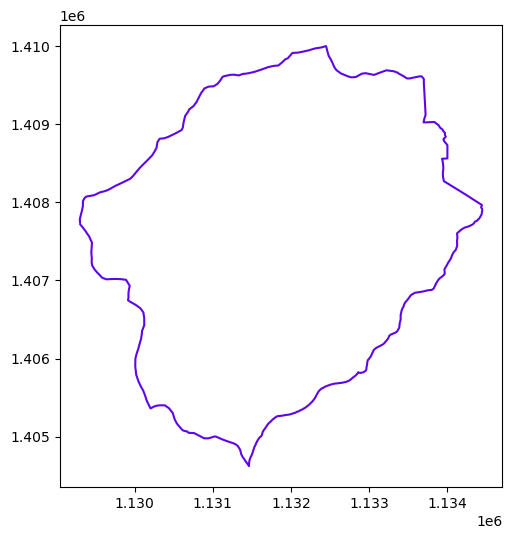

In [12]:
# Construct and plot the WW object used for storing watersheds
watershed = watershed_workflow.split_hucs.SplitHUCs(coweeta)
watershed.plot()

### the Rivers 

In [13]:
# download/collect the river network within that shape's bounds
reaches = sources['hydrography'].getShapesByGeometry(watershed.exterior, crs, out_crs=crs)
rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')

watershed_orig, rivers_orig = watershed, rivers

2025-10-02 15:38:40,866 - root - INFO: fixing column: catchment
2025-10-02 15:38:40,892 - root - INFO: fixing column: geometry


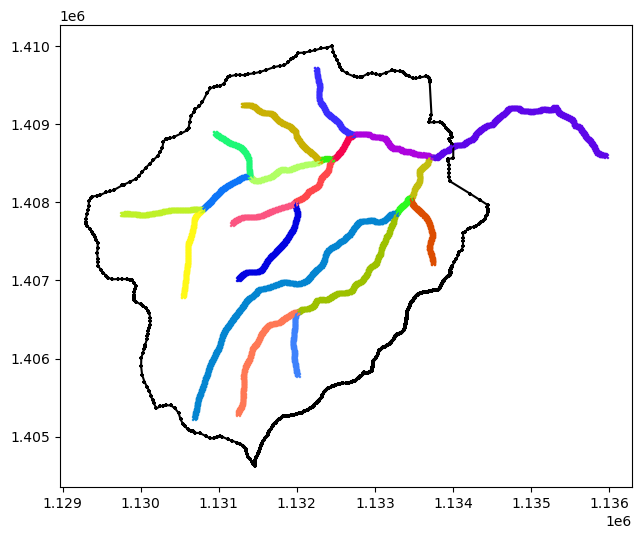

In [14]:
# plot the rivers and watershed
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)

plot(watershed, rivers)

In [15]:
# keeping the originals for plotting comparisons
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]
    

In [16]:
watershed, rivers = createCopy(watershed_orig, rivers_orig)

# simplifying -- this sets the discrete length scale of both the watershed boundary and the rivers
watershed_workflow.simplify(watershed, rivers, refine_L0, refine_L1, refine_d0, refine_d1)

# simplify may remove reaches from the rivers object
# -- this call removes any reaches from the dataframe as well, signaling we are all done removing reaches
#
# ETC: NOTE -- can this be moved into the simplify call?
for river in rivers:
    river.resetDataFrame()

# Now that the river network is set, find the watershed boundary outlets
for river in rivers:
    watershed_workflow.hydrography.findOutletsByCrossings(watershed, river)

2025-10-02 15:38:41,035 - root - INFO: 
2025-10-02 15:38:41,036 - root - INFO: Simplifying
2025-10-02 15:38:41,036 - root - INFO: ------------------------------
2025-10-02 15:38:41,036 - root - INFO: EPSG:5070
2025-10-02 15:38:41,036 - root - INFO: Presimplify to remove colinear, coincident points.
2025-10-02 15:38:41,039 - root - INFO: EPSG:5070
2025-10-02 15:38:41,039 - root - INFO: Pruning leaf reaches < 125
2025-10-02 15:38:41,039 - root - INFO: EPSG:5070
2025-10-02 15:38:41,039 - root - INFO: Merging internal reaches < 125
2025-10-02 15:38:41,040 - root - INFO: EPSG:5070
2025-10-02 15:38:41,041 - root - INFO:   reach: min seg length: 	    4.7213180356 	min geom length: 	  165.1231825964
2025-10-02 15:38:41,041 - root - INFO:   reach: med seg length: 	    5.7469025717 	med geom length: 	  987.4061283623
2025-10-02 15:38:41,041 - root - INFO:   reach: max seg length: 	   28.5938776319 	max geom length: 	 4068.7144554535
2025-10-02 15:38:41,041 - root - INFO: 
2025-10-02 15:38:41,041

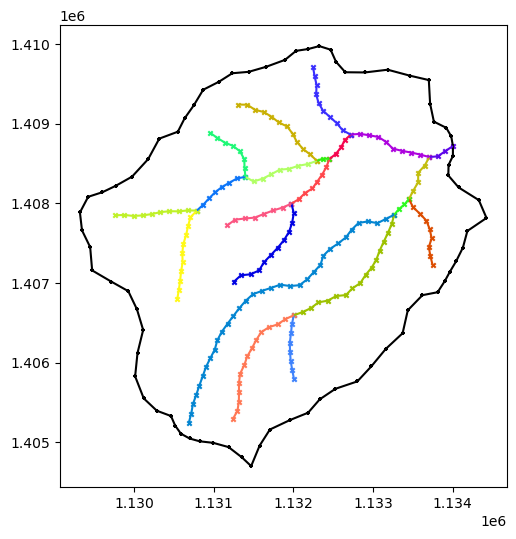

In [17]:
plot(watershed, rivers)

In [18]:
# this generates a zoomable map, showing different reaches and watersheds, 
# with discrete points.  Problem areas are clickable to get IDs for manual
# modifications.
m = watershed.explore(marker=False)
for river in rivers_orig:
    m = river.explore(m=m, column=None, color='black', name=river['name']+' raw', marker=False)
for river in rivers:
    m = river.explore(m=m)
    
m = watershed_workflow.makeMap(m)
m

### Mesh Geometry

Discretely create the stream-aligned mesh.  Download elevation data, and condition the mesh discretely to make for better topography.

2025-10-02 15:38:41,435 - root - INFO: 
2025-10-02 15:38:41,435 - root - INFO: Stream-aligned Meshing
2025-10-02 15:38:41,436 - root - INFO: ------------------------------
2025-10-02 15:38:41,436 - root - INFO: Creating stream-aligned mesh...
2025-10-02 15:38:41,453 - root - INFO: Adjusting HUC to match reaches at outlet
2025-10-02 15:38:41,462 - root - INFO: 
2025-10-02 15:38:41,462 - root - INFO: Triangulation
2025-10-02 15:38:41,463 - root - INFO: ------------------------------
2025-10-02 15:38:41,465 - root - INFO: Triangulating...
2025-10-02 15:38:41,466 - root - INFO:    455 points and 456 facets
2025-10-02 15:38:41,466 - root - INFO:  checking graph consistency
2025-10-02 15:38:41,466 - root - INFO:  tolerance is set to 1.0
2025-10-02 15:38:41,468 - root - INFO:  building graph data structures
2025-10-02 15:38:41,469 - root - INFO:  triangle.build...
2025-10-02 15:38:41,604 - root - INFO:   ...built: 1475 mesh points and 2493 triangles
2025-10-02 15:38:41,605 - root - INFO: Plot

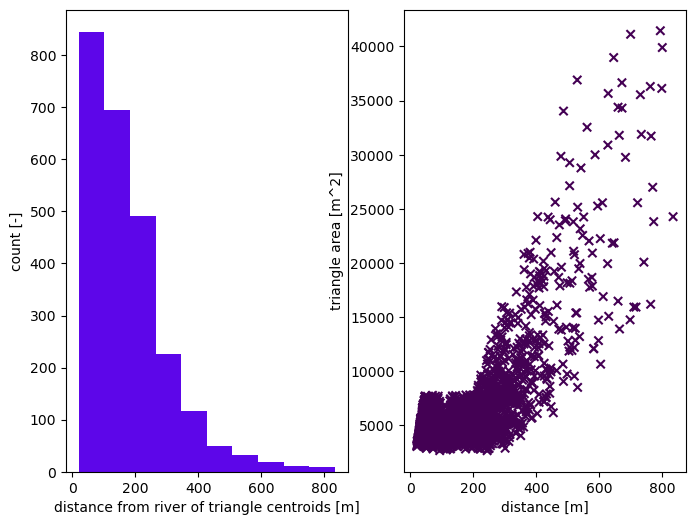

In [19]:
# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width)
widths = dict({1:8,2:12,3:16})

# create the mesh
m2, areas, dists = watershed_workflow.tessalateRiverAligned(watershed, rivers, 
                                                            river_width=widths,
                                                            refine_min_angle=min_angle,
                                                            refine_distance=[refine_d0, refine_A0, refine_d1, refine_A1],
                                                            diagnostics=True)

In [20]:
# prepartition to maintain ordering
m2 = m2.partition(16, True)

In [21]:
# get a raster for the elevation map, based on 3DEP
dem = sources['DEM'].getDataset(watershed.exterior.buffer(100), watershed.crs)['dem']

# provide surface mesh elevations
watershed_workflow.elevate(m2, dem)

2025-10-02 15:38:41,842 - root - INFO: Incoming shape area = 0.0017688403168597767
2025-10-02 15:38:41,842 - root - INFO: ... buffering incoming shape by = 0.00108
2025-10-02 15:38:41,843 - root - INFO: ... buffered shape area = 0.001956767422135052
2025-10-02 15:38:41,843 - root - INFO: Getting DEM with map of area = 0.001956767422135052


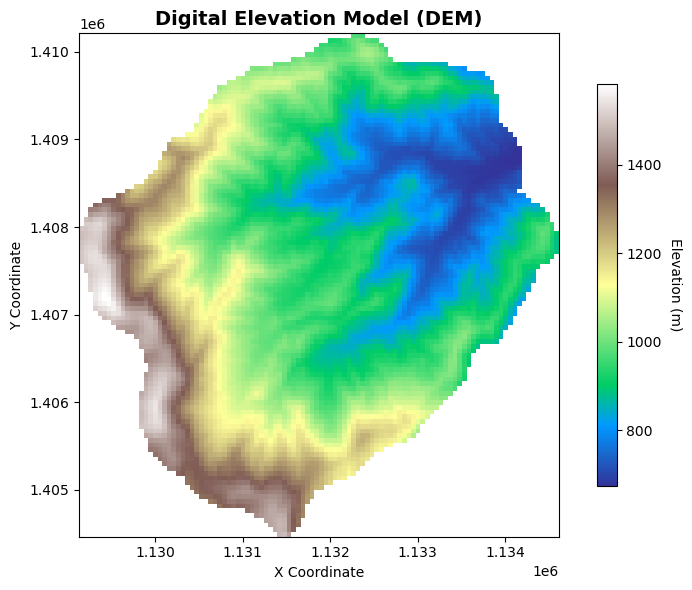

In [22]:
# Plot the DEM raster
fig, ax = plt.subplots()

# Plot the DEM data
im = dem.plot(ax=ax, cmap='terrain', add_colorbar=False)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Elevation (m)', rotation=270, labelpad=15)

# Add title and labels
ax.set_title('Digital Elevation Model (DEM)', fontsize=14, fontweight='bold')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Set equal aspect ratio
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In the pit-filling algorithm, we want to make sure that river corridor is not filled up. Hence we exclude river corridor cells from the pit-filling algorithm.

In [23]:
# hydrologically condition the mesh, removing pits
river_mask=np.zeros((len(m2.conn)))
for i, elem in enumerate(m2.conn):
    if not len(elem)==3:
        river_mask[i]=1     
watershed_workflow.condition.fillPitsDual(m2, is_waterbody=river_mask)

There are a range of options to condition river corridor mesh. We hydrologically condition the river mesh, ensuring unimpeded water flow in river corridors by globally adjusting flowlines to rectify artificial obstructions from inconsistent DEM elevations or misalignments. Please read the documentation for more information


In [24]:
# conditioning river mesh
#
# adding elevations to the river tree for stream bed conditioning
watershed_workflow.condition.setProfileByDEM(rivers, dem)

# conditioning the river mesh using NHD elevations
watershed_workflow.condition.conditionRiverMesh(m2, rivers[0])

2025-10-02 15:38:43,176 - matplotlib.axes._base - WARNING: Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


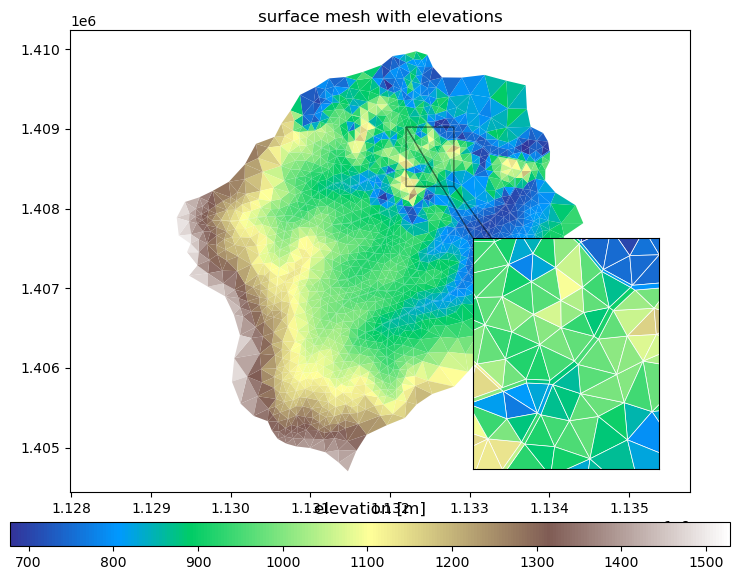

In [25]:
# plotting surface mesh with elevations
fig, ax = plt.subplots()
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.02,0.9,0.04])

mp = m2.plot(facecolors='elevation', edgecolors=None, ax=ax, linewidth=0.5, colorbar=False)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = m2.plot(facecolors='elevation', edgecolors='white', ax=ax2, colorbar=False)
ax2.set_aspect('equal', 'datalim')

xlim = (1.1322e6, 1.1328e6)
ylim = (1.4085e6, 1.4088e6)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()


In [26]:
# add labeled sets for subcatchments and outlets
watershed_workflow.regions.addWatershedAndOutletRegions(m2, watershed, outlet_width=250, exterior_outlet=True)

# add labeled sets for river corridor cells
watershed_workflow.regions.addRiverCorridorRegions(m2, rivers)

# add labeled sets for river corridor cells by order
watershed_workflow.regions.addStreamOrderRegions(m2, rivers)

2025-10-02 15:38:43,279 - root - INFO: Adding regions for 1 polygons


In [27]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 2683 : "0"
10001 : CELL : 2683 : "0 surface"
10002 : FACE : 76 : "0 boundary"
10003 : FACE : 5 : "0 outlet"
10004 : FACE : 5 : "surface domain outlet"
10005 : CELL : 190 : "river corridor 0 surface"
10006 : CELL : 16 : "stream order 3"
10007 : CELL : 48 : "stream order 2"
10008 : CELL : 126 : "stream order 1"


## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

### NLCD for LULC

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [28]:
# download the NLCD raster
nlcd = sources['land cover'].getDataset(watershed.exterior.buffer(100), watershed.crs)['cover']

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(nlcd.dtype))
logging.info('Found land cover types: {}'.format(set(list(nlcd.values.ravel()))))

2025-10-02 15:38:43,344 - root - INFO: Incoming shape area = 0.0017688403168597767
2025-10-02 15:38:43,344 - root - INFO: ... buffering incoming shape by = 0.00027
2025-10-02 15:38:43,345 - root - INFO: ... buffered shape area = 0.0018151848254589866
2025-10-02 15:38:43,388 - root - INFO: Found land cover dtypes: uint8
2025-10-02 15:38:43,390 - root - INFO: Found land cover types: {np.uint8(71), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(81), np.uint8(52), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(127)}


making colormap with: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81), np.uint8(127)]
making colormap with colors: [(0.86666666667, 0.78823529412, 0.78823529412), (0.84705882353, 0.57647058824, 0.50980392157), (0.92941176471, 0.0, 0.0), (0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.8, 0.72941176471, 0.4862745098), (0.8862745098, 0.8862745098, 0.7568627451), (0.85882352941, 0.84705882353, 0.23921568628), (1.0, 1.0, 1.0)]


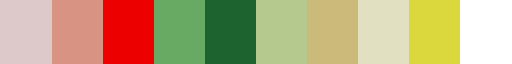

In [29]:
# create a colormap for the data
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(nlcd))
nlcd_cmap

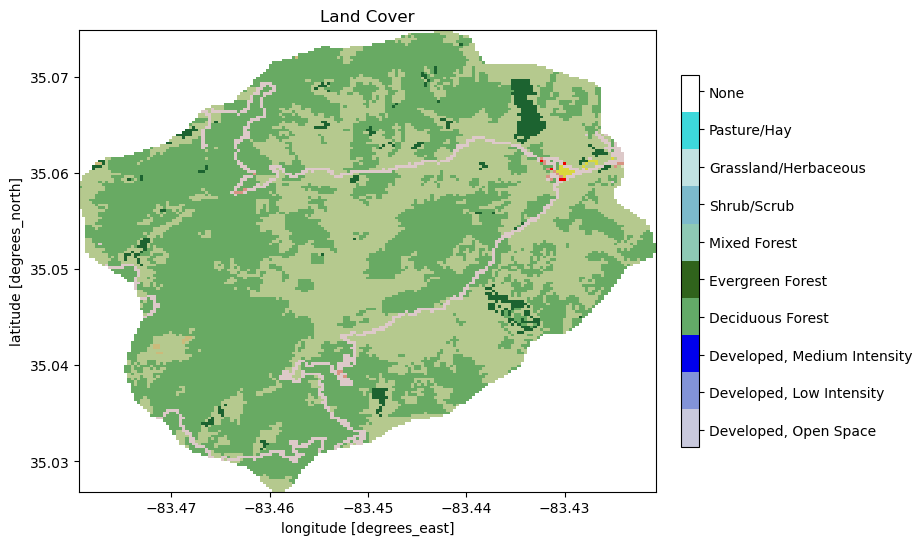

In [30]:
fig, ax = plt.subplots(1,1)
nlcd.plot.imshow(ax=ax, cmap=nlcd_cmap, norm=nlcd_norm, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=ax) 
ax.set_title('Land Cover')
plt.show()

In [31]:
# map nlcd onto the mesh
m2_nlcd = watershed_workflow.getDatasetOnMesh(m2, nlcd, method='nearest')
m2.cell_data['land_cover'] = m2_nlcd



In [32]:
# double-check that nan not in the values
assert 127 not in m2_nlcd

# create a new set of labels and indices with only those that actually appear on the mesh
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(m2_nlcd))


making colormap with: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(81)]
making colormap with colors: [(0.86666666667, 0.78823529412, 0.78823529412), (0.84705882353, 0.57647058824, 0.50980392157), (0.92941176471, 0.0, 0.0), (0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.85882352941, 0.84705882353, 0.23921568628)]


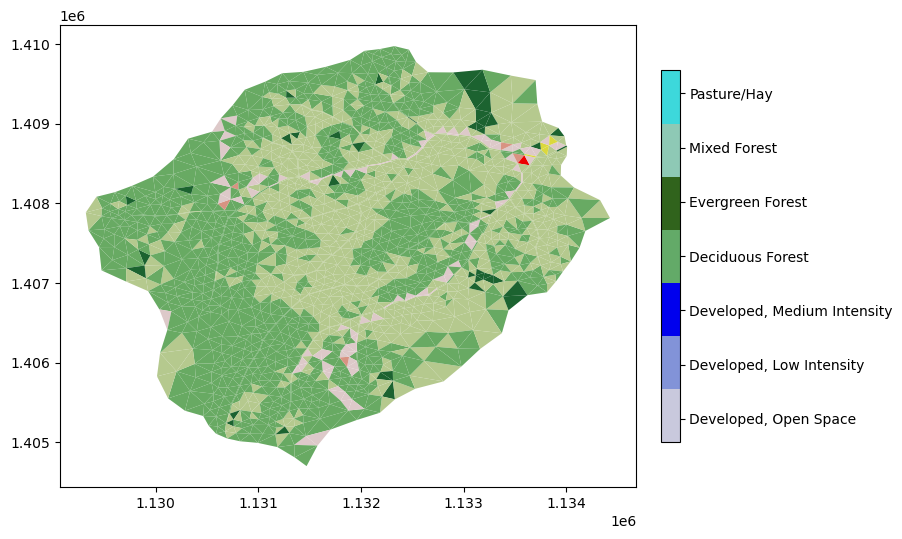

In [33]:
mp = m2.plot(facecolors=m2_nlcd, cmap=nlcd_cmap, norm=nlcd_norm, edgecolors=None, colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=plt.gca()) 
plt.show()

In [34]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.addSurfaceRegions(m2, names=nlcd_labels_dict)

In [35]:
nlcd_labels_dict

{np.uint8(21): 'Developed, Open Space',
 np.uint8(22): 'Developed, Low Intensity',
 np.uint8(23): 'Developed, Medium Intensity',
 np.uint8(41): 'Deciduous Forest',
 np.uint8(42): 'Evergreen Forest',
 np.uint8(43): 'Mixed Forest',
 np.uint8(81): 'Pasture/Hay'}

In [36]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 2683 : "0"
10001 : CELL : 2683 : "0 surface"
10002 : FACE : 76 : "0 boundary"
10003 : FACE : 5 : "0 outlet"
10004 : FACE : 5 : "surface domain outlet"
10005 : CELL : 190 : "river corridor 0 surface"
10006 : CELL : 16 : "stream order 3"
10007 : CELL : 48 : "stream order 2"
10008 : CELL : 126 : "stream order 1"
21 : CELL : 104 : "Developed, Open Space"
22 : CELL : 5 : "Developed, Low Intensity"
23 : CELL : 1 : "Developed, Medium Intensity"
41 : CELL : 1393 : "Deciduous Forest"
42 : CELL : 43 : "Evergreen Forest"
43 : CELL : 1133 : "Mixed Forest"
81 : CELL : 4 : "Pasture/Hay"


### MODIS LAI

Leaf area index is needed on each land cover type -- this is used in the Evapotranspiration calculation.

In [37]:
# download LAI and corresponding LULC datasets -- these are actually already downloaded, 
# as the MODIS AppEEARS API is quite slow
#
# Note that MODIS does NOT work with the noleap calendar, so we have to convert to actual dates first
start_leap = cftime.DatetimeGregorian(start.year, start.month, start.day)
end_leap = cftime.DatetimeGregorian(end.year, end.month, end.day)
res = sources['LAI'].getDataset(watershed.exterior, crs, start_leap, end_leap)


2025-10-02 15:38:43,698 - root - INFO: Incoming shape area = 0.0016040440731829
2025-10-02 15:38:43,699 - root - INFO: ... buffering incoming shape by = 0.0045000000000000005
2025-10-02 15:38:43,699 - root - INFO: ... buffered shape area = 0.0024043957079133795
2025-10-02 15:38:43,700 - root - INFO: Building request for bounds: [np.float64(-83.4825), np.float64(35.0235), np.float64(-83.4176), np.float64(35.0782)]
2025-10-02 15:38:43,700 - root - INFO: ... requires files:
2025-10-02 15:38:43,700 - root - INFO:  ... /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/input_data/land_cover/MODIS/modis_LAI_08-01-2010_08-01-2014_35.0782x-83.4825_35.0235x-83.4176.nc
2025-10-02 15:38:43,701 - root - INFO:  ... /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/input_data/land_cover/MODIS/modis_LULC_08-01-2010_08-01-2014_35.0782x-83.4825_35.0235x-83.4176.nc
2025-10-02 15:38:43,701 - root - INFO: ... files exist locally.


In [38]:
modis_data = res
assert modis_data['LAI'].rio.crs is not None
print(modis_data['LULC'].rio.crs, modis_data['LULC'].dtype)


EPSG:4269 float64


In [39]:
# MODIS data comes with time-dependent LAI AND time-dependent LULC -- just take the mode to find the most common LULC
modis_data['LULC'] = watershed_workflow.data.computeMode(modis_data['LULC'], 'time_LULC')

# now it is safe to have only one time
modis_data = modis_data.rename({'time_LAI':'time'})

# remove leap day (366th day of any leap year) to match our Noleap Calendar
modis_data = watershed_workflow.data.filterLeapDay(modis_data)

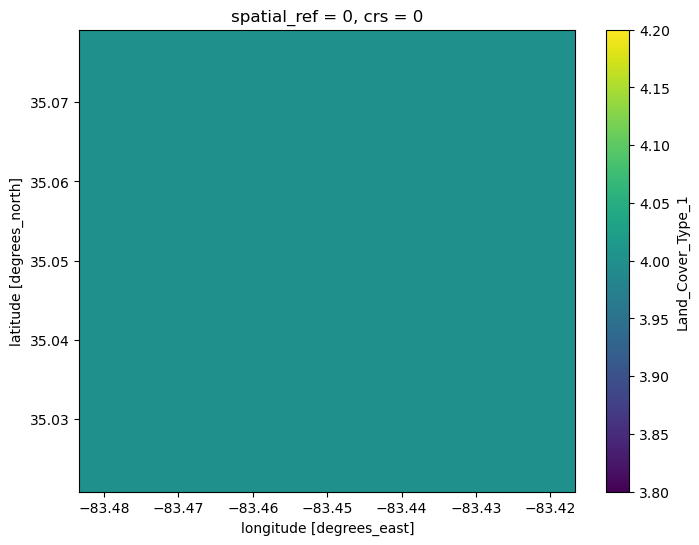

In [40]:
# plot the MODIS data -- note the entire domain is covered with one type for Coweeta (it is small!)
modis_data['LULC'].plot.imshow()

In [41]:
# compute the transient time series
modis_lai = watershed_workflow.land_cover_properties.computeTimeSeries(modis_data['LAI'], modis_data['LULC'], 
                                                                      polygon=watershed.exterior, polygon_crs=watershed.crs)

In [42]:
modis_lai

,time,Deciduous Broadleaf Forests LAI [-]
0,2010-08-01 00:00:00,3.244086
1,2010-08-05 00:00:00,4.813978
2,2010-08-09 00:00:00,3.469892
3,2010-08-13 00:00:00,4.234409
4,2010-08-17 00:00:00,3.178495
...,...,...
364,2014-07-16 00:00:00,5.615054
365,2014-07-20 00:00:00,4.093548
366,2014-07-24 00:00:00,4.000000
367,2014-07-28 00:00:00,4.853763


2025-10-02 15:38:43,934 - root - INFO: Writing HDF5 file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta_LAI_MODIS_transient.h5


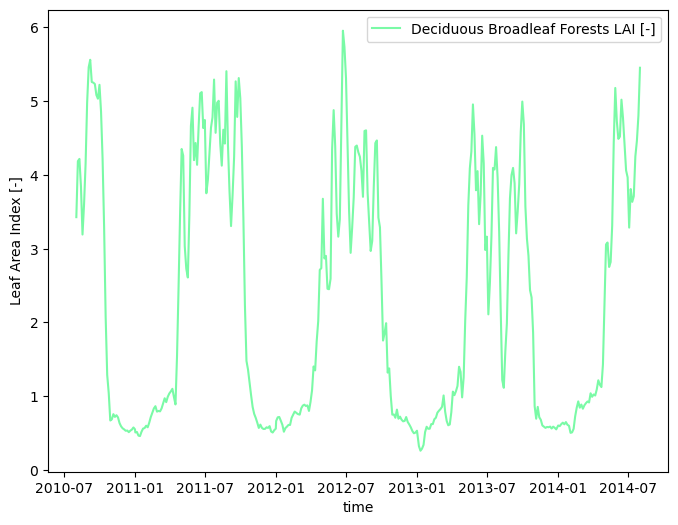

In [43]:
# smooth the data in time
modis_lai_smoothed = watershed_workflow.data.smoothTimeSeries(modis_lai, 'time')

# save the MODIS time series to disk
output_filenames['modis_lai_transient'] = toOutput(f'{name}_LAI_MODIS_transient.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['modis_lai_transient'], modis_lai_smoothed)
watershed_workflow.land_cover_properties.plotLAI(modis_lai_smoothed, indices='MODIS')

2025-10-02 15:38:44,042 - root - INFO: Writing HDF5 file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta_LAI_MODIS_CyclicSteadystate.h5


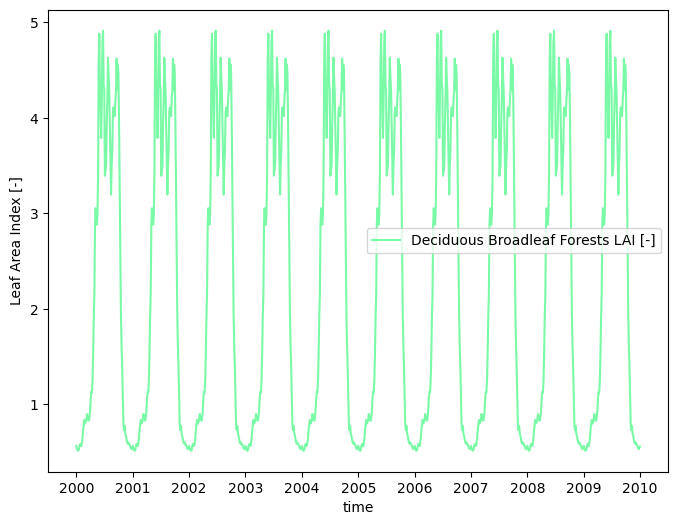

In [44]:
# compute a typical year
modis_lai_typical = watershed_workflow.data.computeAverageYear(modis_lai_smoothed, 'time', output_nyears=10, 
                                                                  start_year=2000)

output_filenames['modis_lai_cyclic_steadystate'] = toOutput(f'{name}_LAI_MODIS_CyclicSteadystate.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['modis_lai_cyclic_steadystate'], modis_lai_typical)
watershed_workflow.land_cover_properties.plotLAI(modis_lai_typical, indices='MODIS')

### Crosswalk of LAI to NLCD LC

2025-10-02 15:38:44,144 - root - INFO: Compute the crosswalk between MODIS and NLCD:
2025-10-02 15:38:44,144 - root - INFO:   unique MODIS: [np.float64(4.0)]
2025-10-02 15:38:44,145 - root - INFO:   unique NLCD: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81)]


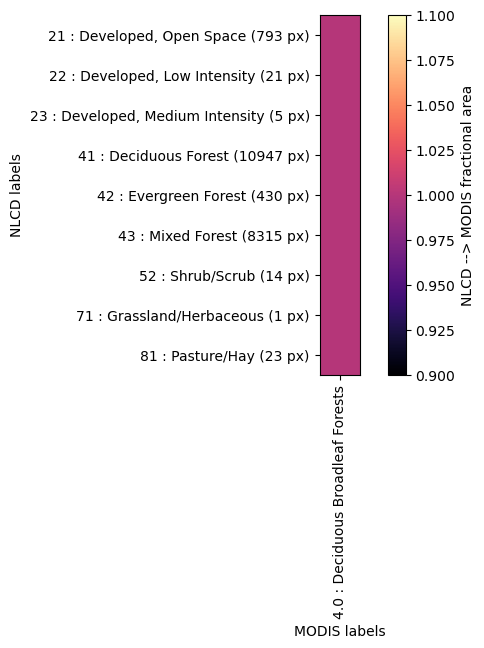

In [45]:
crosswalk = watershed_workflow.land_cover_properties.computeCrosswalk(modis_data['LULC'], nlcd, method='fractional area')

In [46]:
# Compute the NLCD-based time series
nlcd_lai_cyclic_steadystate = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_typical)
nlcd_lai_transient = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_smoothed)

watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_cyclic_steadystate)
watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_transient)
nlcd_lai_transient

None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False
None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False


,time,"Developed, Open Space LAI [-]","Developed, Low Intensity LAI [-]","Developed, Medium Intensity LAI [-]",Deciduous Forest LAI [-],Evergreen Forest LAI [-],Mixed Forest LAI [-],Shrub/Scrub LAI [-],Grassland/Herbaceous LAI [-],Pasture/Hay LAI [-]
0,2010-08-01 00:00:00,3.427880,3.427880,0.0,3.427880,3.427880,3.427880,3.427880,3.427880,3.427880
1,2010-08-05 00:00:00,4.186508,4.186508,0.0,4.186508,4.186508,4.186508,4.186508,4.186508,4.186508
2,2010-08-09 00:00:00,4.217460,4.217460,0.0,4.217460,4.217460,4.217460,4.217460,4.217460,4.217460
3,2010-08-13 00:00:00,3.842960,3.842960,0.0,3.842960,3.842960,3.842960,3.842960,3.842960,3.842960
4,2010-08-17 00:00:00,3.192524,3.192524,0.0,3.192524,3.192524,3.192524,3.192524,3.192524,3.192524
...,...,...,...,...,...,...,...,...,...,...
364,2014-07-16 00:00:00,3.712084,3.712084,0.0,3.712084,3.712084,3.712084,3.712084,3.712084,3.712084
365,2014-07-20 00:00:00,4.249360,4.249360,0.0,4.249360,4.249360,4.249360,4.249360,4.249360,4.249360
366,2014-07-24 00:00:00,4.460855,4.460855,0.0,4.460855,4.460855,4.460855,4.460855,4.460855,4.460855
367,2014-07-28 00:00:00,4.805709,4.805709,0.0,4.805709,4.805709,4.805709,4.805709,4.805709,4.805709


In [47]:
# write the NLCD-based time series to disk
output_filenames['nlcd_lai_cyclic_steadystate'] = toOutput(f'{name}_LAI_NLCD_CyclicSteadystate.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['nlcd_lai_cyclic_steadystate'], nlcd_lai_cyclic_steadystate)

output_filenames['nlcd_lai_transient'] = toOutput(f'{name}_LAI_NLCD_{start.year}_{end.year}.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['nlcd_lai_transient'], nlcd_lai_transient)

2025-10-02 15:38:44,244 - root - INFO: Writing HDF5 file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta_LAI_NLCD_CyclicSteadystate.h5
2025-10-02 15:38:44,246 - root - INFO: Writing HDF5 file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta_LAI_NLCD_2010_2014.h5


## Subsurface Soil, Geologic Structure

### NRCS Soils

In [48]:
# get NRCS shapes, on a reasonable crs
nrcs = sources['soil structure'].getShapesByGeometry(watershed.exterior, watershed.crs, out_crs=crs)
nrcs

2025-10-02 15:38:44,281 - root - INFO: Attempting to download source for target '/home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/input_data/soil_structure/SSURGO/SSURGO_-83.4780_35.0280_-83.4221_35.0737.shp'
2025-10-02 15:38:44,286 - root - INFO:   Found 456 shapes.
2025-10-02 15:38:44,336 - root - INFO: found 41 unique MUKEYs.
2025-10-02 15:38:44,680 - root - INFO: Running Rosetta for van Genutchen parameters
2025-10-02 15:38:44,715 - root - INFO:   ... done
2025-10-02 15:38:44,716 - root - INFO:   requested 41 values
2025-10-02 15:38:44,717 - root - INFO:   got 41 responses
2025-10-02 15:38:44,722 - root - INFO: fixing column: geometry


,mukey,geometry,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],thickness [m],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source,ID,name
0,545800,"MULTIPOLYGON (((1131335.296 1404750.906, 11313...",0.177165,0.431041,0.000139,1.470755,8.079687e-13,2.03,3.429028e-15,0.307246,1.297356,66.356250,19.518750,14.125000,NRCS,545800,NRCS-545800
1,545801,"MULTIPOLYGON (((1129506.994 1406944.207, 11294...",0.177493,0.432741,0.000139,1.469513,8.184952e-13,2.03,3.247236e-15,0.303714,1.292308,66.400000,19.300000,14.300000,NRCS,545801,NRCS-545801
2,545803,"MULTIPOLYGON (((1130760.995 1408224.107, 11307...",0.172412,0.400889,0.000150,1.491087,6.477202e-13,2.03,2.800000e-12,0.379163,1.400000,66.799507,21.700493,11.500000,NRCS,545803,NRCS-545803
3,545805,"MULTIPOLYGON (((1134255.698 1405132.204, 11342...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545805,NRCS-545805
4,545806,"MULTIPOLYGON (((1134180.798 1405169.304, 11341...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545806,NRCS-545806
5,545807,"MULTIPOLYGON (((1131255.496 1405664.406, 11312...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545807,NRCS-545807
6,545811,"MULTIPOLYGON (((1130078.796 1404597.506, 11300...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545811,NRCS-545811
7,545812,"POLYGON ((1130078.496 1404548.906, 1130061.396...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545812,NRCS-545812
8,545813,"MULTIPOLYGON (((1132919.997 1405040.305, 11329...",0.183468,0.398767,0.000127,1.445858,4.296896e-13,2.03,6.219065e-14,0.349442,1.410667,60.007287,26.226047,13.766667,NRCS,545813,NRCS-545813
9,545814,"MULTIPOLYGON (((1131226.596 1404721.006, 11312...",0.183216,0.399168,0.000125,1.445793,4.285058e-13,2.03,6.060887e-14,0.346424,1.406875,59.510029,26.771221,13.718750,NRCS,545814,NRCS-545814


In [49]:
# create a clean dataframe with just the data we will need for ATS
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(nrcs, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(nrcs, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    nrcs.pop(col)
    
# drop nans
nan_mask = nrcs.isna().any(axis=1)
dropped_mukeys = nrcs.index[nan_mask]

# Drop those rows
nrcs = nrcs[~nan_mask]

assert nrcs['porosity [-]'][:].min() >= min_porosity
assert nrcs['permeability [m^2]'][:].max() <= max_permeability
nrcs

# check for nans
nrcs.isna().any()

mukey                          False
geometry                       False
residual saturation [-]        False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
thickness [m]                  False
permeability [m^2]             False
porosity [-]                   False
source                         False
ID                             False
name                           False
dtype: bool

In [50]:
# Compute the soil color of each cell of the mesh
# Note, we use mukey here because it is an int, while ID is a string
soil_color_mukey = watershed_workflow.getShapePropertiesOnMesh(m2, nrcs, 'mukey', 
                                                         resolution=50, nodata=-999)

nrcs.set_index('mukey', drop=False, inplace=True)

unique_soil_colors = list(np.unique(soil_color_mukey))
if -999 in unique_soil_colors:
    unique_soil_colors.remove(-999)

# retain only the unique values of soil_color
nrcs = nrcs.loc[unique_soil_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
nrcs['ATS ID'] = range(1000, 1000+len(unique_soil_colors))
nrcs.set_index('ATS ID', drop=True, inplace=True)

# create a new soil color and a soil thickness map using the ATS IDs
soil_color = -np.ones_like(soil_color_mukey)
soil_thickness = np.nan * np.ones(soil_color.shape, 'd')

for ats_ID, ID, thickness in zip(nrcs.index, nrcs.mukey, nrcs['thickness [m]']):
    mask = np.where(soil_color_mukey == ID)
    soil_thickness[mask] = thickness
    soil_color[mask] = ats_ID

m2.cell_data['soil_color'] = soil_color
m2.cell_data['soil thickness'] = soil_thickness


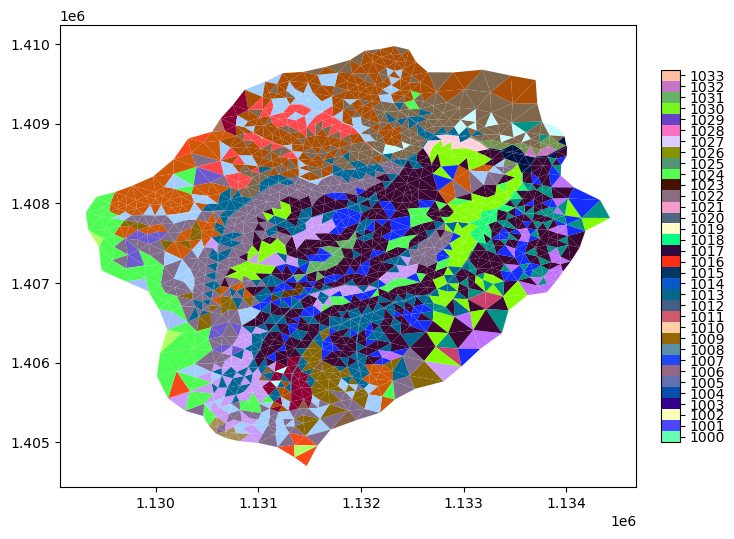

In [51]:
# plot the soil color
# -- get a cmap for soil color
sc_indices, sc_cmap, sc_norm, sc_ticks, sc_labels = \
      watershed_workflow.colors.createIndexedColormap(nrcs.index)

mp = m2.plot(facecolors=m2.cell_data['soil_color'], cmap=sc_cmap, norm=sc_norm, edgecolors=None, colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nrcs), 
                               cmap=sc_cmap, labels=sc_labels, ax=plt.gca()) 
plt.show()

### Depth to Bedrock from SoilGrids

In [52]:
dtb = sources['depth to bedrock'].getDataset(watershed.exterior, watershed.crs)['band_1']

# the SoilGrids dataset is in cm --> convert to meters
dtb.values = dtb.values/100.

2025-10-02 15:38:45,119 - root - INFO: Incoming shape area = 0.0016040429015210392
2025-10-02 15:38:45,119 - root - INFO: ... buffering incoming shape by = 0.0020833330000016304
2025-10-02 15:38:45,119 - root - INFO: ... buffered shape area = 0.00196035495453784


In [53]:
# map to the mesh
m2.cell_data['dtb'] = watershed_workflow.getDatasetOnMesh(m2, dtb, method='linear')


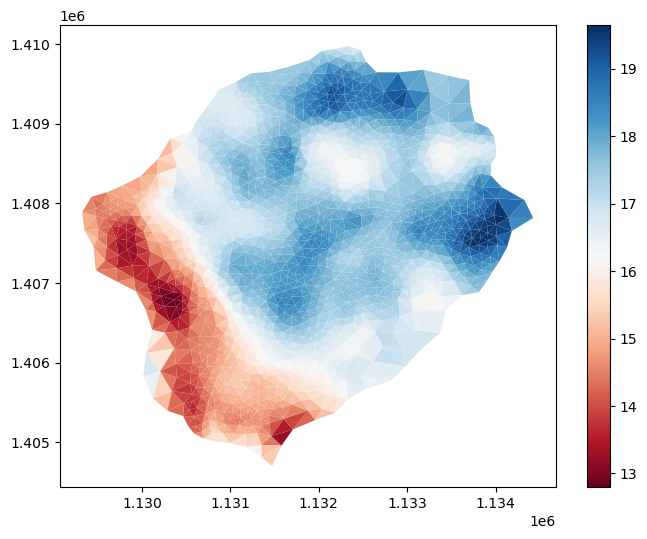

In [54]:
gons = m2.plot(facecolors=m2.cell_data['dtb'], cmap='RdBu', edgecolors=None)
plt.show()

### GLHYMPs Geology

In [55]:
glhymps = sources['geologic structure'].getShapesByGeometry(watershed.exterior.buffer(1000), watershed.crs, out_crs=crs)
glhymps = watershed_workflow.soil_properties.mangleGLHYMPSProperties(glhymps,
                                              min_porosity=min_porosity, 
                                              max_permeability=max_permeability, 
                                              max_vg_alpha=max_vg_alpha)

# intersect with the buffered geometry -- don't keep extras
glhymps = glhymps[glhymps.intersects(watershed.exterior.buffer(10))]
glhymps

2025-10-02 15:38:45,335 - root - INFO: fixing column: geometry


,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
1,1793338,GLHYMPS-1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1060059.466 1375224.917, 10600..."


In [56]:
# quality check -- make sure glymps shapes cover the watershed
print(glhymps.union_all().contains(watershed.exterior))
glhymps

True


,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
1,1793338,GLHYMPS-1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1060059.466 1375224.917, 10600..."


In [57]:
# clean the data
glhymps.pop('logk_stdev [-]')

assert glhymps['porosity [-]'][:].min() >= min_porosity
assert glhymps['permeability [m^2]'][:].max() <= max_permeability
assert glhymps['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

glhymps.isna().any()

ID                             False
name                           False
source                         False
permeability [m^2]             False
porosity [-]                   False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
residual saturation [-]        False
geometry                       False
dtype: bool

In [58]:
# note that for larger areas there are often common regions -- two labels with the same properties -- no need to duplicate those with identical values.
def reindex_remove_duplicates(df, index):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(glhymps, 'ID')
glhymps

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1060059.466 1375224.917, 10600..."


In [59]:
# Compute the geo color of each cell of the mesh
geology_color_glhymps = watershed_workflow.getShapePropertiesOnMesh(m2, glhymps, 'index', 
                                                         resolution=50, nodata=-999)

# retain only the unique values of geology that actually appear in our cell mesh
unique_geology_colors = list(np.unique(geology_color_glhymps))
if -999 in unique_geology_colors:
    unique_geology_colors.remove(-999)

# retain only the unique values of geology_color
glhymps = glhymps.loc[unique_geology_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
glhymps['ATS ID'] = range(100, 100+len(unique_geology_colors))
glhymps['TMP_ID'] = glhymps.index
glhymps.reset_index(drop=True, inplace=True)
glhymps.set_index('ATS ID', drop=True, inplace=True)

# create a new geology color using the ATS IDs
geology_color = -np.ones_like(geology_color_glhymps)
for ats_ID, tmp_ID in zip(glhymps.index, glhymps.TMP_ID):
    geology_color[np.where(geology_color_glhymps == tmp_ID)] = ats_ID

glhymps.pop('TMP_ID')

m2.cell_data['geology_color'] = geology_color
                            

In [60]:
geology_color_glhymps.min()

<xarray.DataArray 'index' ()> Size: 8B
array(0)

### Combine to form a complete subsurface dataset

In [61]:
bedrock = watershed_workflow.soil_properties.getDefaultBedrockProperties()

# merge the properties databases
subsurface_props = pd.concat([glhymps, nrcs, bedrock])

# save the properties to disk for use in generating input file
output_filenames['subsurface_properties'] = toOutput(f'{name}_subsurface_properties.csv')
subsurface_props.to_csv(output_filenames['subsurface_properties'])
subsurface_props


,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.050000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((1060059.466 1375224.917, 10600...",NaN,NaN
1000,545800,NRCS-545800,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,"MULTIPOLYGON (((1131335.296 1404750.906, 11313...",545800.0,2.03
1001,545803,NRCS-545803,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,"MULTIPOLYGON (((1130760.995 1408224.107, 11307...",545803.0,2.03
1002,545805,NRCS-545805,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1134255.698 1405132.204, 11342...",545805.0,2.03
1003,545806,NRCS-545806,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1134180.798 1405169.304, 11341...",545806.0,2.03
1004,545807,NRCS-545807,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1131255.496 1405664.406, 11312...",545807.0,2.03
1005,545811,NRCS-545811,NRCS,1.830706e-12,0.329821,0.000166,1.473045,0.185628,"MULTIPOLYGON (((1130078.796 1404597.506, 11300...",545811.0,2.03
1006,545813,NRCS-545813,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,"MULTIPOLYGON (((1132919.997 1405040.305, 11329...",545813.0,2.03
1007,545814,NRCS-545814,NRCS,6.060887e-14,0.346424,0.000125,1.445793,0.183216,"MULTIPOLYGON (((1131226.596 1404721.006, 11312...",545814.0,2.03
1008,545815,NRCS-545815,NRCS,3.794887e-14,0.319402,0.000162,1.498482,0.177808,"MULTIPOLYGON (((1131297.396 1404750.606, 11313...",545815.0,2.03


## Extrude the 2D Mesh to make a 3D mesh

In [62]:
# set the floor of the domain as max DTB
dtb_max = np.nanmax(m2.cell_data['dtb'].values)
m2.cell_data['dtb'] = m2.cell_data['dtb'].fillna(dtb_max)

print(f'total thickness: {dtb_max} m')
total_thickness = 50.


total thickness: 19.647739130592548 m


In [63]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimizeDzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.05447108 0.07161305 0.11027281 0.17443206 0.26441087 0.36782677
 0.45697337 0.49999999]
2.0000000000000004


In [64]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

2.0


In [65]:
# 50m total thickness, minus 2m soil thickness, leaves us with 48 meters to make up.
# optimize again...
dzs2, res2 = watershed_workflow.mesh.optimizeDzs(1, 10, 48, 8)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1.0, 2.0, 4.0, 8.0, 11, 11, 11]
print(dzs_geo)
print(sum(dzs_geo))

[2.71113048 5.85796948 9.43304714 9.99786869 9.99998875 9.99999546]
48.0
[1.0, 2.0, 4.0, 8.0, 11, 11, 11]
48.0


In [66]:
# layer extrusion
DTB = m2.cell_data['dtb'].values
soil_color = m2.cell_data['soil_color'].values
geo_color = m2.cell_data['geology_color'].values
soil_thickness = m2.cell_data['soil thickness'].values


# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # use glhymps params
    br_or_geo = np.where(depth < DTB, geo_color, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                                 soil_color,
                                 br_or_geo)

    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    geo_or_br = np.where(depth < DTB, geo_color, 999)

    layer_mat_ids.append(geo_or_br)
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarizeExtrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]
subsurface_props_used


2025-10-02 15:38:45,957 - root - INFO: Cell summary:
2025-10-02 15:38:45,957 - root - INFO: ------------------------------------------------------------
2025-10-02 15:38:45,957 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2025-10-02 15:38:45,957 - root - INFO: ------------------------------------------------------------
2025-10-02 15:38:45,957 - root - INFO:  00 	| 00 	| 1020 	|   0.050000 	|   0.000000
2025-10-02 15:38:45,957 - root - INFO:  01 	| 01 	| 1020 	|   0.050000 	|   0.050000
2025-10-02 15:38:45,958 - root - INFO:  02 	| 02 	| 1020 	|   0.050000 	|   0.100000
2025-10-02 15:38:45,958 - root - INFO:  03 	| 03 	| 1020 	|   0.120000 	|   0.150000
2025-10-02 15:38:45,958 - root - INFO:  04 	| 04 	| 1020 	|   0.230000 	|   0.270000
2025-10-02 15:38:45,958 - root - INFO:  05 	| 05 	| 1020 	|   0.500000 	|   0.500000
2025-10-02 15:38:45,959 - root - INFO:  06 	| 06 	| 1020 	|   0.500000 	|   1.000000
2025-10-02 15:38:45,959 - root - INFO:  07 	| 07 	| 1020 	|   0.500000 	|   1.5

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.050000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((1060059.466 1375224.917, 10600...",NaN,NaN
999,999,bedrock,n/a,1.000000e-16,0.050000,0.000019,3.000000,0.010000,None,NaN,NaN
1000,545800,NRCS-545800,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,"MULTIPOLYGON (((1131335.296 1404750.906, 11313...",545800.0,2.03
1001,545803,NRCS-545803,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,"MULTIPOLYGON (((1130760.995 1408224.107, 11307...",545803.0,2.03
1002,545805,NRCS-545805,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1134255.698 1405132.204, 11342...",545805.0,2.03
1003,545806,NRCS-545806,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1134180.798 1405169.304, 11341...",545806.0,2.03
1004,545807,NRCS-545807,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1131255.496 1405664.406, 11312...",545807.0,2.03
1005,545811,NRCS-545811,NRCS,1.830706e-12,0.329821,0.000166,1.473045,0.185628,"MULTIPOLYGON (((1130078.796 1404597.506, 11300...",545811.0,2.03
1006,545813,NRCS-545813,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,"MULTIPOLYGON (((1132919.997 1405040.305, 11329...",545813.0,2.03
1007,545814,NRCS-545814,NRCS,6.060887e-14,0.346424,0.000125,1.445793,0.183216,"MULTIPOLYGON (((1131226.596 1404721.006, 11312...",545814.0,2.03


In [67]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [68]:
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
for ls in m3.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
for ls in m3.side_sets:
    print(f'{ls.setid} : FACE : {len(ls.cell_list)} : "{ls.name}"')
    

2D labeled sets
---------------
10000 : CELL : 2683 : "0"
10001 : CELL : 2683 : "0 surface"
10002 : FACE : 76 : "0 boundary"
10003 : FACE : 5 : "0 outlet"
10004 : FACE : 5 : "surface domain outlet"
10005 : CELL : 190 : "river corridor 0 surface"
10006 : CELL : 16 : "stream order 3"
10007 : CELL : 48 : "stream order 2"
10008 : CELL : 126 : "stream order 1"
21 : CELL : 104 : "Developed, Open Space"
22 : CELL : 5 : "Developed, Low Intensity"
23 : CELL : 1 : "Developed, Medium Intensity"
41 : CELL : 1393 : "Deciduous Forest"
42 : CELL : 43 : "Evergreen Forest"
43 : CELL : 1133 : "Mixed Forest"
81 : CELL : 4 : "Pasture/Hay"

Extruded 3D labeled sets
------------------------
10000 : CELL : 40245 : "0"

Extruded 3D side sets
---------------------
1 : FACE : 2683 : "bottom"
2 : FACE : 2683 : "surface"
3 : FACE : 1140 : "external sides"
10001 : FACE : 2683 : "0 surface"
10002 : FACE : 1140 : "0 boundary"
10003 : FACE : 75 : "0 outlet"
10004 : FACE : 75 : "surface domain outlet"
10005 : FACE : 1

In [69]:
# save the mesh to disk
output_filenames['mesh'] = toOutput(f'{name}.exo')
try:
    os.remove(output_filenames['mesh'])
except FileNotFoundError:
    pass
m3.writeExodus(output_filenames['mesh'])


You are using exodus.py v 1.21.6 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013-2023 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta.exo


2025-10-02 15:38:46,189 - root - INFO: writing partition data as variable
2025-10-02 15:38:46,193 - root - INFO: adding side set: 1
2025-10-02 15:38:46,201 - root - INFO: adding side set: 2
2025-10-02 15:38:46,204 - root - INFO: adding side set: 3
2025-10-02 15:38:46,206 - root - INFO: adding side set: 10001
2025-10-02 15:38:46,208 - root - INFO: adding side set: 10002
2025-10-02 15:38:46,210 - root - INFO: adding side set: 10003
2025-10-02 15:38:46,211 - root - INFO: adding side set: 10004
2025-10-02 15:38:46,212 - root - INFO: adding side set: 10005
2025-10-02 15:38:46,214 - root - INFO: adding side set: 10006
2025-10-02 15:38:46,215 - root - INFO: adding side set: 10007
2025-10-02 15:38:46,216 - root - INFO: adding side set: 10008
2025-10-02 15:38:46,217 - root - INFO: adding side set: 21
2025-10-02 15:38:46,218 - root - INFO: adding side set: 22
2025-10-02 15:38:46,219 - root - INFO: adding side set: 23
2025-10-02 15:38:46,221 - root - INFO: adding side set: 41
2025-10-02 15:38:46,

Closing exodus file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta.exo


## Meteorological forcing dataset

In [70]:
# download the data -- note it is hourly!
met_data_raw = sources['meteorology'].getDataset(watershed.exterior, crs, start_leap, end_leap)

# convert it to daily mean immediately
met_data_raw_daily = met_data_raw.resample(time=datetime.timedelta(hours=24)).mean()

# also, note that we sampled from 8/1 to 8/1, meaning we have an extra day now.
met_data_raw_daily = met_data_raw_daily.isel({'time' : slice(0, -1)})
print(f'Total days: {len(met_data_raw_daily['time'])}')


2025-10-02 15:38:46,356 - root - INFO: Incoming shape area = 0.0016040429015210392
2025-10-02 15:38:46,356 - root - INFO: ... buffering incoming shape by = 0.00833333
2025-10-02 15:38:46,357 - root - INFO: ... buffered shape area = 0.0031753726729616284


  Using existing: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/input_data/meteorology/aorc/aorc_2010-2014_35.0821x-83.4138_35.0197x-83.4863.nc
Total days: 1461


In [71]:
# AORC is a non-projected dataset in lat-lon
# warp it to projected
met_data_warped = watershed_workflow.warp.dataset(met_data_raw_daily, crs, 'bilinear')

# convert and write ATS format for transient run
met_data_transient = watershed_workflow.meteorology.convertAORCToATS(met_data_warped)
met_data_transient


2025-10-02 15:38:49,430 - root - INFO: Converting AORC to ATS met input


<xarray.Dataset> Size: 8MB
Dimensions:                                (x: 9, y: 9, time: 1461)
Coordinates:
  * x                                      (x) float64 72B 1.128e+06 ... 1.13...
  * y                                      (y) float64 72B 1.41e+06 ... 1.404...
  * time                                   (time) object 12kB 2010-08-01 00:0...
    spatial_ref                            int64 8B 0
Data variables:
    air temperature [K]                    (time, y, x) float64 947kB nan ......
    incoming shortwave radiation [W m^-2]  (time, y, x) float64 947kB nan ......
    incoming longwave radiation [W m^-2]   (time, y, x) float64 947kB nan ......
    vapor pressure air [Pa]                (time, y, x) float64 947kB nan ......
    wind speed [m s^-1]                    (time, y, x) float64 947kB nan ......
    precipitation total [m s^-1]           (time, y, x) float64 947kB nan ......
    precipitation rain [m s^-1]            (time, y, x) float64 947kB 0.0 ......
    precipitation snow [m SWE s^-1]        (time, y, x) float64 947kB 0.0 ......
Attributes:
    name:                             AORC v1.1
    source:                           NOAA AWS S3 Zarr
    wind speed reference height [m]:  10.0

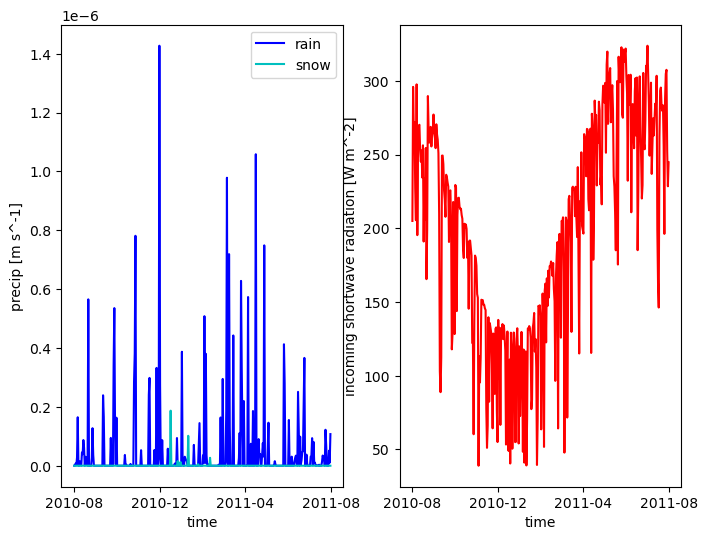

In [72]:
# plot a few of the met data -- does it look reasonable?
def plotMetData(met, x=5, y=5):
    """plot one pixel as a function of time"""
    fig = plt.figure()
    ax = fig.add_subplot(121)
    
    met_data_single_pixel = met.isel({'time':slice(0,365),
                                               'x' : 5,
                                               'y' : 5})
    
    met_data_single_pixel['precipitation rain [m s^-1]'].plot(color='b', label='rain')
    met_data_single_pixel['precipitation snow [m SWE s^-1]'].plot(color='c', label='snow')
    ax.set_ylabel('precip [m s^-1]')
    ax.set_title('')
    ax.legend()
    
    ax = fig.add_subplot(122)
    met_data_single_pixel['incoming shortwave radiation [W m^-2]'].plot(color='r', label='qSW_in')
    ax.set_ylabel('incoming shortwave radiation [W m^-2]')
    ax.set_title('')
    
    plt.show()

plotMetData(met_data_transient)

In [73]:
# write transient data to disk
filename = toOutput(f'{name}_aorc-{start.year}-{end.year}.h5')
output_filenames['meteorology_transient'] = filename
watershed_workflow.io.writeDatasetToHDF5(
    filename,
    met_data_transient
    )

2025-10-02 15:38:49,572 - root - INFO: Writing HDF5 file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta_aorc-2010-2014.h5


In [74]:
# compute the typical year
# note that we have to do this only on no-leap data to line up the days
#
# also, we do this on the original variables and then re-compute ATS quantities
ndays = met_data_warped['APCP_surface'].shape[0]
print('nyears = ', ndays // 365)
print('n days leftover = ', ndays % 365)
print('note, that leftover day(s) are leap day(s).')


nyears =  4
n days leftover =  1
note, that leftover day(s) are leap day(s).


In [75]:
# cannot compute a typical year for leap year -- need to align days-of-the-year
# remove leap day (Dec 31 of leap years)
met_data_noleap = watershed_workflow.data.filterLeapDay(met_data_warped)
met_data_noleap

# then compute a "typical" year
met_data_typical = watershed_workflow.data.computeAverageYear(met_data_noleap, 'time', 2010, nyears_cyclic_steadystate)

# and lastly convert to ATS
met_data_typical_ats = watershed_workflow.meteorology.convertAORCToATS(met_data_typical)

2025-10-02 15:38:50,388 - root - INFO: Converting AORC to ATS met input


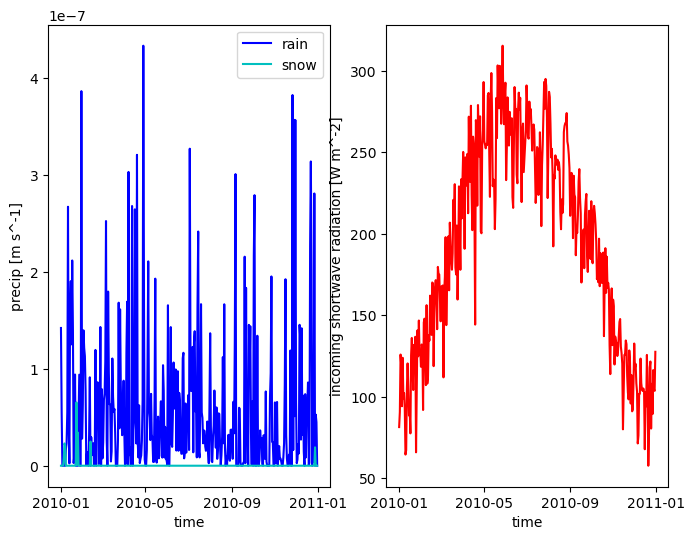

In [76]:
# plot a few of the met data -- does it look reasonable?
plotMetData(met_data_typical_ats)

In [77]:
# write cyclic steadystate data to disk
filename = toOutput(f'{name}_daymet-CyclicSteadystate.h5')
output_filenames['meteorology_cyclic_steadystate'] = filename
watershed_workflow.io.writeDatasetToHDF5(
    filename,
    met_data_typical_ats,
    met_data_typical_ats.attrs)


2025-10-02 15:38:50,502 - root - INFO: Writing HDF5 file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta_daymet-CyclicSteadystate.h5


In [78]:
# compute the average precip rate for steadystate solution
precip_mean = (met_data_transient['precipitation rain [m s^-1]'].data + met_data_transient['precipitation snow [m SWE s^-1]'].data).mean()
logging.info(f'Mean precip value = {precip_mean}')


2025-10-02 15:38:50,994 - root - INFO: Mean precip value = 5.502343508705227e-08


## Write ATS input files

Now we have the mesh file written and all of the forcing datasets (meteorology, LAI) written.  It remains to write ATS XML files that will be the runs.

There are three runs done:

- steadystate: forces a surface + subsurface only problem with constant, uniform precip until true steadystate
- cyclic steadystate: forces with a typical year of averaged data
- transient: runs with real daily data from start to end

In [79]:
# Note that each of these are defined as functions so we can reuse them for all three input files.

# add the subsurface and surface domains
#
# Note this also adds a "computational domain" region to the region list, and a vis spec 
# for "domain"
def add_domains(main_list, mesh, surface_region='surface', snow=True, canopy=True):
    ats_input_spec.public.add_domain(main_list, 
                                 domain_name='domain', 
                                 dimension=3, 
                                 mesh_type='read mesh file',
                                 mesh_args={'file':mesh})
    if surface_region:
        main_list['mesh']['domain']['build columns from set'] = surface_region    
    
        # Note this also adds a "surface domain" region to the region list and a vis spec for 
        # "surface"
        ats_input_spec.public.add_domain(main_list,
                                domain_name='surface',
                                dimension=2,
                                mesh_type='surface',
                                mesh_args={'surface sideset name':'surface'})
    if snow:
        # Add the snow and canopy domains, which are aliases to the surface
        ats_input_spec.public.add_domain(main_list,
                                domain_name='snow',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})
    if canopy:
        ats_input_spec.public.add_domain(main_list,
                                domain_name='canopy',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})


In [80]:
def add_land_cover(main_list):
    # next write a land-cover section for each NLCD type
    for index, nlcd_name in zip(nlcd_indices, nlcd_labels):
        ats_input_spec.public.set_land_cover_default_constants(main_list, nlcd_name)

    land_cover_list = main_list['state']['model parameters']['land cover types']
    # update some defaults for
    # ['Other', 'Deciduous Forest']
    # note, these are from the CLM Technical Note v4.5
    #
    # Rooting depth curves from CLM TN 4.5 table 8.3
    #
    # Note, the mafic potential values are likely pretty bad for the types of van Genuchten 
    # curves we are using (ETC -- add paper citation about this topic).  Likely they need
    # to be modified.  Note that these values are in [mm] from CLM TN 4.5 table 8.1, so the 
    # factor of 10 converts to [Pa]
    #
    # Note, albedo of canopy taken from CLM TN 4.5 table 3.1
    land_cover_list['Deciduous Forest']['rooting profile alpha [-]'] = 6.0
    land_cover_list['Deciduous Forest']['rooting profile beta [-]'] = 2.0
    land_cover_list['Deciduous Forest']['rooting depth max [m]'] = 10.0
    land_cover_list['Deciduous Forest']['capillary pressure at fully closed stomata [Pa]'] = 224000
    land_cover_list['Deciduous Forest']['capillary pressure at fully open stomata [Pa]'] = 35000 * .10
    land_cover_list['Deciduous Forest']['albedo of canopy [-]'] = 0.1



In [81]:
# add soil sets: note we need a way to name the set, so we use, e.g. SSURGO-MUKEY.
def soil_set_name(ats_id):
    return subsurface_props_used.loc[ats_id, 'name']

def add_soil_properties(main_list):
    # add soil material ID regions, porosity, permeability, and WRMs
    for ats_id in subsurface_props_used.index:
        props = subsurface_props_used.loc[ats_id]
        set_name = soil_set_name(ats_id)
        
        if props['van Genuchten n [-]'] < 1.5:
            smoothing_interval = 0.01
        else:
            smoothing_interval = 0.0
        
        ats_input_spec.public.add_soil_type(main_list, set_name, ats_id, output_filenames['mesh'],
                                            float(props['porosity [-]']),
                                            float(props['permeability [m^2]']), 1.e-7,
                                            float(props['van Genuchten alpha [Pa^-1]']),
                                            float(props['van Genuchten n [-]']),
                                            float(props['residual saturation [-]']),
                                            float(smoothing_interval))    



In [82]:
# get an ATS "main" input spec list -- note, this is a dummy and is not used to write any files yet
def get_main(steadystate=False):
    main_list = ats_input_spec.public.get_main()

    # add the mesh and all domains
    mesh = os.path.join('..', output_filenames['mesh'])
    add_domains(main_list, mesh)

    # tell the partitioner to use our pre-partition from cell_data
    main_list['mesh']['domain']['partitioner'] = 'from exodus file'

    # add labeled sets
    for ls in m3.labeled_sets:
        ats_input_spec.public.add_region_labeled_set(main_list, ls.name, ls.setid, mesh, ls.entity)
    for ss in m3.side_sets:
        ats_input_spec.public.add_region_labeled_set(main_list, ss.name, ss.setid, mesh, 'FACE')
    
    # add land cover
    add_land_cover(main_list)

    # add soil properties
    add_soil_properties(main_list)
        
    # add observations for each subcatchment
    if steadystate:
        time_args = {'cycles start period stop':[0,10,-1],}
        obs = ats_input_spec.public.add_observation(main_list, "water_balance_computational_domain",
                                               "water_balance_computational_domain.csv", obs_args=time_args)
        obs_precip = ats_input_spec.public.add_observable(obs, 'water source [m^3 s^-1]', 'surface-precipitation', 'computational domain', 'integral', 'cell')
        obs_q = ats_input_spec.public.add_observable(obs, 'net runoff [mol s^-1]', 'surface-water_flux', 'computational domain boundary', 'extensive integral', 'face')
        obs_q['direction normalized flux'] = True

        obs_wc = ats_input_spec.public.add_observable(obs, 'subsurface water content [mol]', 'water_content', 'computational domain', 'extensive integral', 'cell')
        obs_wc = ats_input_spec.public.add_observable(obs, 'surface water content [mol]', 'surface-water_content', 'surface domain', 'extensive integral', 'cell')    

    else:
        ats_input_spec.public.add_observations_water_balance(main_list, "computational domain", 
                                                        "surface domain", "external sides")

    return main_list


In [83]:
def populate_basic_properties(xml, main_xml):
    """This function updates an xml object with the above properties for mesh, regions, soil props, and lc props"""
    # find and replace the mesh list
    xml.replace('mesh', asearch.child_by_name(main_xml, 'mesh'))

    # find and replace the regions list
    xml.replace('regions', asearch.child_by_name(main_xml, 'regions'))

    # update the observations list
    obs = next(i for (i,el) in enumerate(xml) if el.get('name') == 'observations')
    xml[obs] = asearch.child_by_name(main_xml, 'observations')

    # update all model parameters lists
    xml_parlist = asearch.find_path(xml, ['state', 'model parameters'], no_skip=True)
    for parlist in asearch.find_path(main_xml, ['state', 'model parameters'], no_skip=True):
        try:
            xml_parlist.replace(parlist.getName(), parlist)
        except aerrors.MissingXMLError:
            xml_parlist.append(parlist)

    # update all evaluator lists
    xml_elist = asearch.find_path(xml, ['state', 'evaluators'], no_skip=True)
    for elist in asearch.find_path(main_xml, ['state', 'evaluators'], no_skip=True):
        try:
            xml_elist.replace(elist.getName(), elist)
        except aerrors.MissingXMLError:
            xml_elist.append(elist)    
    
    # find and replace land cover
    mp_list = asearch.find_path(xml, ['state', 'model parameters'], no_skip=True)
    lc_list = asearch.find_path(main_xml, ['state', 'model parameters', 'land cover types'], no_skip=True)
    
    try:
        mp_list.replace('land cover types', lc_list)
    except aerrors.MissingXMLError:
        mp_list.append(lc_list)


For the first file, we load a spinup template and write the needed quantities into that file, saving it to the appropriate run directory.  Note there is no DayMet or land cover or LAI properties needed for this run.  The only property that is needed is the domain-averaged, mean annual rainfall rate.  We then take off some for ET (note too wet spins up faster than too dry, so don't take off too much...).

In [84]:
def write_spinup_steadystate(name, precip_mean, **kwargs):
    # create the main list
    main = get_main(steadystate=True)

    # set precip to 0.6 * the mean precip value
    precip = main['state']['evaluators'].append_empty('surface-precipitation')
    precip.set_type('independent variable constant', ats_input_spec.public.known_specs['evaluator-independent-variable-constant-spec'])
    precip['value'] = float(precip_mean * .6)

    
    # load the template file
    prefix = 'steadystate'
    xml = aio.fromFile(toInput(f'{prefix}-template.xml'))
    
    # update the template xml with the main xml generated here
    main_xml = ats_input_spec.io.to_xml(main)
    populate_basic_properties(xml, main_xml, **kwargs)

    # write to disk
    output_filenames[f'ats_xml_{prefix}'] = toWorkingDir(f'{name}-{prefix}.xml')
    filename = output_filenames[f'ats_xml_{prefix}']
    aio.toFile(xml, filename)

    # create a run directory
    output_filenames[f'ats_rundir_{prefix}'] = toWorkingDir(f'{name}-{prefix}')
    rundir = output_filenames[f'ats_rundir_{prefix}']
    os.makedirs(rundir, exist_ok=True)


For the second file, we load a transient run template.  This file needs the basics, plus DayMet and LAI as the "typical year data".  Also we set the run directory that will be used for the steadystate run.

For the third file, we load a transient run template as well.  This file needs the basics, DayMet with the actual data, and we choose for this run to use the MODIS typical year.  MODIS is only available for 2002 on, so if we didn't need 1980-2002 we could use the real data, but for this run we want a longer record.

In [85]:
def write_transient(name, cyclic_steadystate=False, **kwargs):
    # make a unique name based on options
    logging.info(f'Writing transient: {name}')

    if cyclic_steadystate:
        prefix = 'cyclic_steadystate'
        previous = 'steadystate'
    else:
        prefix = 'transient'
        previous = 'cyclic_steadystate'

    main = get_main()

    # add the DayMet evaluators
    if cyclic_steadystate:
        daymet_filename = output_filenames['meteorology_cyclic_steadystate']
    else:
        daymet_filename = output_filenames['meteorology_transient']
    ats_input_spec.public.add_daymet_box_evaluators(main, os.path.join('..', daymet_filename), True)

    # add the LAI filenames
    if cyclic_steadystate:
        lai_filename = output_filenames['nlcd_lai_cyclic_steadystate']
    else:
        lai_filename = output_filenames['nlcd_lai_transient']
    ats_input_spec.public.add_lai_point_evaluators(main, os.path.join('..', lai_filename), list(nlcd_labels_dict.values()))
    
    # load the template file
    template_filename = toInput(f'{prefix}-template.xml')
    xml = aio.fromFile(template_filename)

    # update the template xml with the main xml generated here
    main_xml = ats_input_spec.io.to_xml(main)
    populate_basic_properties(xml, main_xml, **kwargs)
    
    # update the start and end time -- would be nice to set these in main, but it would be 
    # confusing as to when to copy them in populate_basic_properties and when not to do so.
    start_day = 274
    if cyclic_steadystate:
        end_day = 274 + (nyears_cyclic_steadystate - 1) * 365 
    else:
        end_day = 274 + (end - start).days 
        
    par = asearch.find_path(xml, ['cycle driver', 'start time'])
    par.setValue(start_day)

    par = asearch.find_path(xml, ['cycle driver', 'end time'])
    par.setValue(end_day)
    
    # update the restart filenames
    for var in asearch.findall_path(xml, ['initial conditions', 'restart file']):
        var.setValue(os.path.join('..', output_filenames[f'ats_rundir_{previous}'], 'checkpoint_final.h5'))
   
    # write to disk and make a directory for running the run
    output_filenames[f'ats_xml_{prefix}'] = toWorkingDir(f'{name}-{prefix}.xml')
    filename = output_filenames[f'ats_xml_{prefix}']

    output_filenames[f'ats_rundir_{prefix}'] = toWorkingDir(f'{name}-{prefix}')
    rundir = output_filenames[f'ats_rundir_{prefix}']

    aio.toFile(xml, filename)
    os.makedirs(rundir, exist_ok=True)

In [86]:
write_spinup_steadystate(name, precip_mean)
write_transient(name, True)
write_transient(name, False)

/home/ecoon/code/ats/ats_input_spec/repos/master/ats_input_spec/io.py:43: UserWarning: Creating an incomplete XML object, missing entries!
  warnings.warn('Creating an incomplete XML object, missing entries!')
2025-10-02 15:38:51,126 - root - INFO: Writing transient: Coweeta
2025-10-02 15:38:51,148 - root - INFO: Writing transient: Coweeta


## Completion and Summary

After this is complete, the following should work:

```
cd /path/to/ww/examples/Coweeta/Coweeta-steadystate
mpiexec -n 4 ats ../Coweeta-steadystate.xml &> out.log
cd ../Coweeta-cyclic_steadystate
mpiexec -n 4 ats ../Coweeta-cyclic_steadystate.xml &> out.log
cd ../Coweeta-transient
mpiexec -n 4 ats ../Coweeta-transient.xml &> out.log
```

In [87]:
# the following files were generated during this run:
print(f'{"role":<35}: filename')
print('-'*34, ': ', '-'*50)
for k,v in output_filenames.items():
    vs = list(splitPathFull(v))
    if vs[-2] == 'Coweeta':
        v2 = vs[-1]
    else:
        v2 = os.path.join(vs[-2], vs[-1])
    
    print(f'{k:<35}: {v2}')

role                               : filename
---------------------------------- :  --------------------------------------------------
modis_lai_transient                : output_data/Coweeta_LAI_MODIS_transient.h5
modis_lai_cyclic_steadystate       : output_data/Coweeta_LAI_MODIS_CyclicSteadystate.h5
nlcd_lai_cyclic_steadystate        : output_data/Coweeta_LAI_NLCD_CyclicSteadystate.h5
nlcd_lai_transient                 : output_data/Coweeta_LAI_NLCD_2010_2014.h5
subsurface_properties              : output_data/Coweeta_subsurface_properties.csv
mesh                               : output_data/Coweeta.exo
meteorology_transient              : output_data/Coweeta_aorc-2010-2014.h5
meteorology_cyclic_steadystate     : output_data/Coweeta_daymet-CyclicSteadystate.h5
ats_xml_steadystate                : Coweeta-steadystate.xml
ats_rundir_steadystate             : Coweeta-steadystate
ats_xml_cyclic_steadystate         : Coweeta-cyclic_steadystate.xml
ats_rundir_cyclic_steadystate      : Cowe

In [88]:
logging.info('this workflow is a total success!')

2025-10-02 15:38:51,203 - root - INFO: this workflow is a total success!


In [89]:
# double-checking correct centroid info
np.save('m3_bary_centroids.npy', m3.barycentric_centroids)